## Hyperperameter optimization of WaveNet

We're going to train a full, regularized CNN architecture with some automatic hyperperameter optimization using `hyperas` (a wrapper for `hyperopt`).

In [1]:
import logging
import numpy as np
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

from hyperopt import Trials, STATUS_OK, tpe
from hyperopt.pyll.base import scope
from hyperas import optim
from hyperas.distributions import choice, uniform, quniform
from hyperas.utils import eval_hyperopt_space

import tools.train as train
import tools.models as models
import tools.plot as plot

# Suppress tensorflow warnings about internal deprecations
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

## Count data
files = ("../data/mitbih_train.csv", "../data/mitbih_test.csv")
inputs, labels, sparse_labels, df = train.preprocess(*files, fft=False)
# Add a dimension for "channels"
for key in inputs:
    inputs[key] = tf.expand_dims(inputs[key], axis=2)
train.class_count(df)

Using TensorFlow backend.



Train set
Count of each class
Classes
0.0    72471
1.0     2223
2.0     5788
3.0      641
4.0     6431
dtype: int64

Test set
Count of each class
Classes
0.0    18118
1.0      556
2.0     1448
3.0      162
4.0     1608
dtype: int64


In [2]:
# functions for hyperas
def data():
    ## Read in data
    files = ("../data/mitbih_train.csv", "../data/mitbih_test.csv")
    inputs, labels, sparse_labels, df = train.preprocess(*files, fft=False)
    # Add a dimension for "channels"
    for key in inputs:
        inputs[key] = tf.expand_dims(inputs[key], axis=2)
    
    return inputs, labels

def create_model(inputs, labels):
    
    nblocks = {{quniform(3.5, 20.5, 1)}}
    nfilters = {{quniform(31.5, 128.5, 1)}}
    batch_size = {{quniform(49.5, 500.5, 1)}}
    l1_reg = {{uniform(0, 0.1)}}
    l2_reg = {{uniform(0, 0.1)}}
    
    dilation_limit = {{quniform(0.5, inputs["train"].shape[1], 1)}}
    
    # Start
    layerlist_res = [("conv", {"filters": int(nfilters), "width": 1, "padding": "causal"})]

    # Residual blocks
    models.add_res_blocks(int(nblocks), int(nfilters), dilation_limit, layerlist_res)

    # End
    layerlist_res.extend([
        (layers.Activation("relu"),),
        ("conv", {"filters": int(nfilters), "width": 1, "padding": "causal"}),
        ("conv", {"filters": 1, "width": 1, "padding": "causal"}),
        (layers.Dropout({{uniform(0, 1)}}),)
    ])

    config = {
        "optimizer": "Nadam",
        "loss": "sparse_categorical_crossentropy",
        "batch_size": int(batch_size),
        "val_split": 0.4,
        "epochs": 8,
        "verbose": 0,
        "patience": 5,
        "weighted_metrics": ["accuracy"],
        "regularizer": regularizers.l1_l2(l1=l1_reg, l2=l2_reg),
     }

    inputsize = inputs["train"].shape[1]
    ncategories = labels["train"].shape[1]
    model_res = models.create_conv1d(inputsize, layerlist_res, ncategories, config)
    history = train.train(model_res, inputs, sparse_labels, config)
    
    # get the lowest validation loss of the training epochs
    validation_acc = np.amax(history.history['val_accuracy_1'])
    return {'loss': -validation_acc, 'status': STATUS_OK, 'model': model_res}

best_run, best_model, space = optim.minimize(
    model=create_model,
    data=data,
    algo=tpe.suggest,
    max_evals=50,
    eval_space=True,
    return_space=True,
    trials=Trials(),
    notebook_name='wavenet_hyperopt',
    verbose=False,
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [7:05:41<00:00, 599.02s/it, best loss: -0.982782244682312]


Chosen hyperparameters from the best-trained model
{'Dropout': 0.11849011630764406, 'batch_size': 127.0, 'dilation_limit': 23.0, 'l1_reg': 0.00020208366862898815, 'l1_reg_1': 0.0268783897138795, 'nblocks': 12.0, 'nfilters': 76.0}
Train acc of best performing model after 15 epochs: 0.98377
Test acc of best performing model after 15 epochs: 0.9782112
Confusion matrix, without normalization
[[17965    90    49     3    11]
 [  128   417    10     0     1]
 [   44     0  1393     8     3]
 [   39     1    21   101     0]
 [   43     4    22     0  1539]]


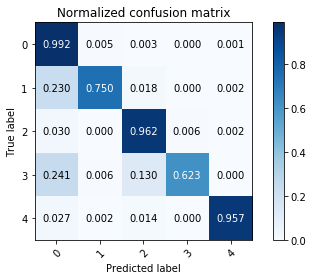

In [3]:
print("Chosen hyperparameters from the best-trained model")
print(best_run)

print(
    "Train acc of best performing model after 10 epochs:",
    best_model.evaluate(inputs["train"], sparse_labels["train"], verbose=0)[1],
)
print(
    "Test acc of best performing model after 10 epochs:",
    best_model.evaluate(inputs["test"], sparse_labels["test"], verbose=0)[1],
)

test_pred = np.argmax(best_model.predict(inputs["test"]), axis=1)
plot.plot_cm(
    sparse_labels["test"],
    test_pred,
    classes=np.arange(5),
    normalize=True,
    norm_fmt=".3f",
)